<a href="https://colab.research.google.com/github/PiKaChu-wcg/pytorch/blob/main/Generative.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision.datasets as dsets
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.utils as vutil


import matplotlib.pyplot as plt
import numpy as np

import os
# !wget www.di.ens.fr/~lelarge/MNIST.tar.gz
# !tar -zxvf MNIST.tar.gz

In [7]:
image_size=28
input_dim=100
num_channels=1
num_features=64
batch_size=64
use_cuda=torch.cuda.is_available()
dtype=torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
itype=torch.cuda.LongTensor if use_cuda else torch.LongTensor
train_dataset = dsets.MNIST(root='./data',  #文件存放路径
                            train=True,   #提取训练集
                            transform=transforms.ToTensor(),  #将图像转化为Tensor，在加载数据的时候，就可以对图像做预处理
                            download=True)
test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)
indices = range(len(test_dataset))
indices_val = indices[:5000]
indices_test = indices[5000:]
sampler_val = torch.utils.data.sampler.SubsetRandomSampler(indices_val)
sampler_test = torch.utils.data.sampler.SubsetRandomSampler(indices_test)
validation_loader = torch.utils.data.DataLoader(dataset =test_dataset,
                                                batch_size = batch_size,
                                                sampler = sampler_val
                                               )
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          sampler = sampler_test
                                         )

In [12]:
class ModuleG(nn.Module):
    def __init__(self):
        super(ModuleG,self).__init__()
        self.model=nn.Sequential()
        self.model.add_module('deconv1',nn.ConvTranspose2d(input_dim,num_features*2,5,22,0,bias=False))
        self.model.add_module('bonrm1',nn.BatchNorm2d(num_features*2))
        self.model.add_module('relu1',nn.ReLU(True))
        self.model.add_module('deconv2',nn.ConvTranspose2d(num_features*2,num_features,5,2,0,bias=False))
        self.model.add_module('bonrm2',nn.BatchNorm2d(num_features))
        self.model.add_module('relu2',nn.ReLU(True))
        self.model.add_module('deconv3',nn.ConvTranspose2d(num_features, num_channels, 4, 2, 0,bias=False))
        self.model.add_module('sigmoid',nn.Sigmoid())
    def forward(self,input):
        output=input
        for name,module in self.model.named_children():
            output=module(output)
        return (output)
def weight_init(m):
    class_name=m.__class__.__name__
    if  class_name.find('conv')!=-1:
        m.weight.data.normal_(0,0.02)
    if class_name.find('norm')!=-1:
        m.weight.data.normal_(1.0,0.02)
def make_show(img):
    img=img.data.expand(batch_size,3,image_size,image_size)
    return img

def imshow(inp, title=None):
    # 在屏幕上绘制图像
    """Imshow for Tensor."""
    if inp.size()[0] > 1:
        inp = inp.numpy().transpose((1, 2, 0))
    else:
        inp = inp[0].numpy()
    mvalue = np.amin(inp)
    maxvalue = np.amax(inp)
    if maxvalue > mvalue:
        inp = (inp - mvalue)/(maxvalue - mvalue)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

In [13]:
net=ModuleG()
net=net.cuda() if use_cuda else net
criterion=nn.MSELoss()
optimizer=optim.SGD(net.parameters(),lr=0.01,momentum=0.9)
samples=np.random.choice(10,batch_size)
samples=torch.from_numpy(samples).type(dtype)
step=0
num_epochs=20
record=[]
for epoch in range(num_epochs):
    train_loss=[]
    for batch_idx,(data,target) in enumerate(train_loader):
        target,data=data.clone().detach().requires_grad_(True),target.clone().detach()
        if use_cuda:
            target, data = target.cuda(), data.cuda()
        data = data.type(dtype)
        data = data.resize(data.size()[0], 1, 1, 1)
        data = data.expand(data.size()[0], input_dim, 1, 1)
        net.train()
        output=net(data)
        loss=criterion(output,target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        step+=1
        if use_cuda:
            loss = loss.cpu()
        train_loss.append(loss.data.numpy())
        
        
        if step % 100 == 0: #每间隔100个batch执行一次打印等操作    
            net.eval() # 给网络模型做标记，标志说模型在校验集上运行
            val_loss = [] #记录校验数据集准确率的容器
            
            '''开始在校验数据集上做循环，计算校验集上面的准确度'''
            idx = 0
            for (data, target) in validation_loader:
                target, data = data.clone().detach().requires_grad_(True), target.clone().detach()
                idx += 1
                if use_cuda:
                    target, data = target.cuda(), data.cuda()
                data = data.type(dtype)
                data = data.resize(data.size()[0], 1, 1, 1)
                data = data.expand(data.size()[0], input_dim, 1, 1)
                output = net(data) #完成一次前馈计算过程，得到目前训练得到的模型net在校验数据集上的表现
                loss = criterion(output, target) #将output与标签target比较，计算误差
                if use_cuda:
                    loss = loss.cpu()
                val_loss.append(loss.data.numpy())
                #打印误差等数值，其中正确率为本训练周期Epoch开始后到目前撮的正确率的平均值
            print('训练周期: {} [{}/{} ({:.0f}%)]\t训练数据Loss: {:.6f}\t校验数据Loss: {:.6f}'.format(
                epoch, batch_idx * batch_size, len(train_loader.dataset),
                100. * batch_idx / len(train_loader), np.mean(train_loss), np.mean(val_loss)))
            record.append([np.mean(train_loss), np.mean(val_loss)])
        
    
    # 产生一组图像保存到temp1文件夹下（需要事先建立好该文件夹），检测生成器当前的效果
    # 改变输入数字的尺寸，适应于生成器网络
    with torch.no_grad():
        samples.resize_(batch_size,1,1,1)
    samples = samples.data.expand(batch_size, input_dim, 1, 1)
    samples = samples.cuda() if use_cuda else samples #加载到GPU
    fake_u=net(samples) #用原始网络作为输入，得到伪造的图像数据
    fake_u = fake_u.cpu() if use_cuda else fake_u
    img = make_show(fake_u) #将张量转化成可绘制的图像
    os.makedirs('temp1',exist_ok=True)
    vutil.save_image(img,'temp1/fake%s.png'% (epoch)) #保存生成的图像      

/usr/local/lib/python3.7/dist-packages/torch/tensor.py:474: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


训练周期: 0 [6336/60000 (11%)]	训练数据Loss: 0.097351	校验数据Loss: 0.067149
训练周期: 0 [12736/60000 (21%)]	训练数据Loss: 0.082248	校验数据Loss: 0.063185
训练周期: 0 [19136/60000 (32%)]	训练数据Loss: 0.076504	校验数据Loss: 0.061889
训练周期: 0 [25536/60000 (43%)]	训练数据Loss: 0.073442	校验数据Loss: 0.061225
训练周期: 0 [31936/60000 (53%)]	训练数据Loss: 0.071488	校验数据Loss: 0.060725
训练周期: 0 [38336/60000 (64%)]	训练数据Loss: 0.070171	校验数据Loss: 0.060385
训练周期: 0 [44736/60000 (75%)]	训练数据Loss: 0.069146	校验数据Loss: 0.060154
训练周期: 0 [51136/60000 (85%)]	训练数据Loss: 0.068343	校验数据Loss: 0.060318
训练周期: 0 [57536/60000 (96%)]	训练数据Loss: 0.067699	校验数据Loss: 0.060135
训练周期: 1 [3904/60000 (7%)]	训练数据Loss: 0.063023	校验数据Loss: 0.059663
训练周期: 1 [10304/60000 (17%)]	训练数据Loss: 0.062274	校验数据Loss: 0.059338
训练周期: 1 [16704/60000 (28%)]	训练数据Loss: 0.062284	校验数据Loss: 0.059474
训练周期: 1 [23104/60000 (38%)]	训练数据Loss: 0.062095	校验数据Loss: 0.059355
训练周期: 1 [29504/60000 (49%)]	训练数据Loss: 0.062150	校验数据Loss: 0.059544
训练周期: 1 [35904/60000 (60%)]	训练数据Loss: 0.062080	校验数据Loss: 0.058910
训练周期: 1 [4230

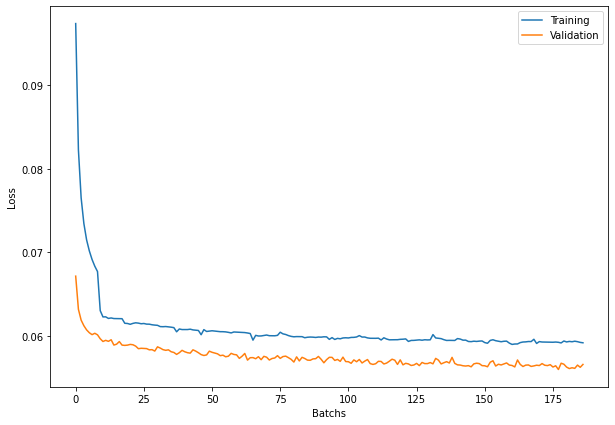

In [24]:
plt.figure(figsize = (10, 7))
plt.plot([i[0] for i in record], label='Training')
plt.plot([i[1] for i in record], label='Validation')
plt.xlabel('Batchs')
plt.ylabel('Loss')
plt.legend()


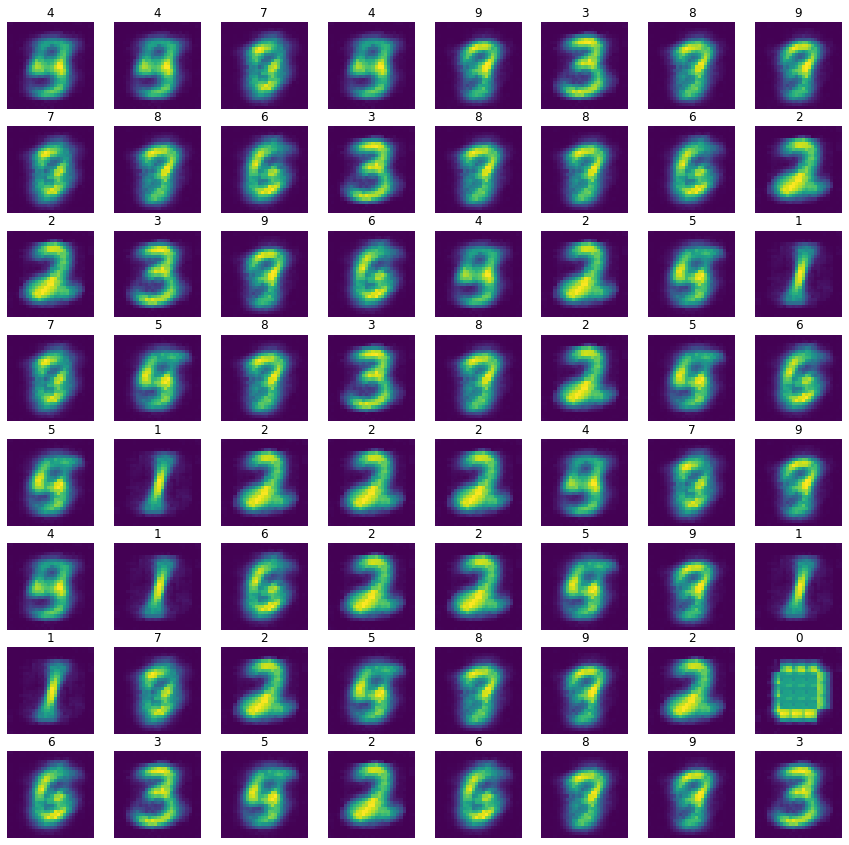

In [25]:
fake_u = fake_u.cpu() if use_cuda else fake_u
samples = samples.cpu() if use_cuda else samples
img = fake_u.data #将张量转化成可绘制的图像
fig = plt.figure(figsize = (15, 15))

for i in range(batch_size):
    ax = plt.subplot(8,8,i+1)
    ax.axis('off')
    imshow(img[i].data, samples.data.numpy()[i][0,0,0].astype(int))

In [47]:
netR=models.resnet18(pretrained=True)
netR=netR.cuda() if use_cuda else netR

In [50]:
for param in netR.parameters():
    param.requires_grad=False
num_ftrs=netR.fc.in_features
netR.fc=nn.Linear(num_ftrs,10).cuda()
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(netR.parameters(),lr=0.001,momentum=0.9)
for epoch in range(10):
    for batch_idx,(data,target) in enumerate(train_loader):
        data,target=data.clone().detach().requires_grad_(True),target.clone().detach()
        data=data.expand(data.size()[0],3,28,28)
        if use_cuda:
            target, data = target.cuda(), data.cuda()
        output=netR(data)
        
        loss=criterion(output,target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [42]:
data,target=next(iter(train_loader))

In [43]:
data.expand()

torch.Size([64, 1, 28, 28])

In [52]:
for param in netR.parameters():
    param.requires_grad=False


In [55]:
#开始训练

print('Initialized!')

netG = ModuleG() #新建一个生成器
netG = netG.cuda() if use_cuda else netG #加载到GPU上
netG.apply(weight_init) #初始化参数

criterion = nn.CrossEntropyLoss() #用交叉熵作为损失函数
optimizer = optim.SGD(netG.parameters(), lr=0.0001, momentum=0.9) #定义优化器

#随机选择batch_size个数字，用他们来生成数字图像
samples = np.random.choice(10, batch_size)
samples = torch.from_numpy(samples).type(dtype).requires_grad_(False)

num_epochs = 100 #总训练周期
statistics = [] #数据记载器
for epoch in range(num_epochs):
    train_loss = []
    train_rights = []
    
    # 加载数据
    for batch_idx, (data, target) in enumerate(train_loader):
        # 注意图像和标签互换了
        target, data = data.clone().detach().requires_grad_(True), target.clone().detach() #data为一批标签，target为一批图像
        if use_cuda:
            target, data = target.cuda(), data.cuda()
        # 复制标签变量放到了label中
        label = data.clone()
        data = data.type(dtype)
        # 改变张量形状以适用于生成器网络
        data = data.resize(data.size()[0], 1, 1, 1)
        data = data.expand(data.size()[0], input_dim, 1, 1)

        netG.train() # 给网络模型做标记，标志说模型正在训练集上训练，
        netR.train() #这种区分主要是为了打开关闭net的training标志，从而决定是否运行dropout
        output1 = netG(data) #神经网络完成一次前馈的计算过程，得到预测输出output
        output=output.expand(output.size()[0],3,28,28)
        output = netR(output1) #用识别器网络来做分类
        loss = criterion(output, label) #将output与标签target比较，计算误差
        optimizer.zero_grad() #清空梯度
        loss.backward() #反向传播
        optimizer.step() #一步随机梯度下降算法
        step += 1
        if use_cuda:
            loss = loss.cpu()
        train_loss.append(loss.data.numpy())
        right = rightness(output, label) #计算准确率所需数值，返回数值为（正确样例数，总样本数）
        train_rights.append(right) #将计算结果装到列表容器train_rights中
        
        if step % 100 == 0: #每间隔100个batch执行一次打印等操作
            
            netG.eval() # 给网络模型做标记，标志说模型正在校验集上运行，
            netR.eval() #这种区分主要是为了打开关闭net的training标志，从而决定是否运行dropout
            val_loss = [] #记录校验数据集准确率的容器
            val_rights = []
            
            '''开始在校验数据集上做循环，计算校验集上面的准确度'''
            for (data, target) in validation_loader:
                # 注意target是图像，data是标签
                target, data = data.clone().detach().requires_grad_(True), target.clone().detach()
                if use_cuda:
                    target, data = target.cuda(), data.cuda()
                label = data.clone()
                data = data.type(dtype)
                #改变Tensor大小以适应生成网络
                data = data.resize(data.size()[0], 1, 1, 1)
                data = data.expand(data.size()[0], input_dim, 1, 1)
                
                output1 = netG(data) #神经网络完成一次前馈的计算过程，得到预测输出output
                output = netR(output1) #利用识别器来识别
                loss = criterion(output, label) #将output与标签target比较，计算误差
                if use_cuda:
                    loss = loss.cpu()
                val_loss.append(loss.data.numpy())
                right = rightness(output, label) #计算准确率所需数值，返回正确的数值为（正确样例数，总样本数）
                val_rights.append(right)
            # 分别计算在目前已经计算过的测试数据集，以及全部校验集上模型的表现：分类准确率
            #train_r为一个二元组，分别记录目前已经经历过的所有训练集中分类正确的数量和该集合中总的样本数，
            #train_r[0]/train_r[1]就是训练集的分类准确度，同样，val_r[0]/val_r[1]就是校验集上的分类准确度
            train_r = (sum([tup[0] for tup in train_rights]), sum([tup[1] for tup in train_rights]))
            #val_r为一个二元组，分别记录校验集中分类正确的数量和该集合中总的样本数
            val_r = (sum([tup[0] for tup in val_rights]), sum([tup[1] for tup in val_rights]))
            print(('训练周期: {} [{}/{} ({:.0f}%)]\t训练数据Loss: {:.6f},正确率: {:.2f}%\t校验数据Loss:' +
                  '{:.6f},正确率:{:.2f}%').format(epoch, batch_idx * batch_size, len(train_loader.dataset),
                100. * batch_idx / len(train_loader), np.mean(train_loss), 
                                               100. * train_r[0].cpu().numpy() / train_r[1], 
                                               np.mean(val_loss), 
                                               100. * val_r[0].cpu.numpy() / val_r[1]))
            #记录中间的数据
            statistics.append({'loss':np.mean(train_loss),'train': 100. * train_r[0] / train_r[1],
                               'valid':100. * val_r[0] / val_r[1]})
            
    # 产生一组图像保存到temp1文件夹下（需要事先建立好该文件夹），检测生成器当前的效果
    with torch.no_grad():
        samples.resize_(batch_size,1,1,1)
    samples = samples.data.expand(batch_size, input_dim, 1, 1)
    samples = samples.cuda() if use_cuda else samples
    fake_u=netG(samples)
    fake_u = fake_u.cpu() if use_cuda else fake_u
    img = make_show(fake_u)
    os.makedirs('temp1',exist_ok=True)
    vutil.save_image(img,'temp1/fake%s.png'% (epoch))

Initialized!


/usr/local/lib/python3.7/dist-packages/torch/tensor.py:474: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


RuntimeError: ignored

In [57]:
ModuleG()

ModuleG(
  (model): Sequential(
    (deconv1): ConvTranspose2d(100, 128, kernel_size=(5, 5), stride=(22, 22), bias=False)
    (bonrm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (deconv2): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), bias=False)
    (bonrm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (deconv3): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (sigmoid): Sigmoid()
  )
)